In [1]:
#Ode Solver
from qutip import *
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from odeintw import odeintw



import math
import random
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from numpy import linalg as LA
import copy
import time
import gc
%load_ext memory_profiler

In [2]:
def quad_func(t,a):
    return a*t**2

In [3]:
import sys
sys.path.append('../Überarbeitung/.')
from init_atoms import *

#### Funktionen für exakte Diagonalisierung

In [4]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
    global eigenvectors2
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    eigenvalues, eigenvectors = LA.eigh(H)
    eigenvectors2=copy.copy(eigenvectors)
    #print("Time for Linearisierung: ",time.time()-start)

    return eigenvalues, eigenvectors,H

In [5]:
def ultimate_justeins(eigen_values,eigenvectors,times_tmp,angeregt):
    
    total_steps=len(times_tmp)
#Zeitenwicklung--------------------------------------------------------------------------------------------
    #start = time.time()
    projection=eigenvectors[angeregt]
    psi_t= np.zeros((total_steps,number_atoms,1),dtype="complex64")
    for i,t in enumerate(times_tmp):
        psi_t[i]= (eigenvectors @ (np.exp(-1j*eigenvalues*t)*projection))[:,None]
        
    #print("Time for Probability_Zeitentwicklung: ",time.time()-start)
    
    #komplette Zeitenwicklung ohne Schleife, aber leider langsamer:
            #psi_t2= ((eigenvectors*np.exp(-1j*eigen_values*times_tmp[:,None])[:,None])@projection)[:,:,None]
    
    
#Wahrscheinlichkeiten---------------------------------------------------------------------------------------
    #start = time.time()
    np.square(np.absolute(psi_t,out=psi_t),out=psi_t)    # now psi_all_t = probability
    #print("Time for Probability_wahrscheinlichkeit: ",time.time()-start)

    probability=np.real(psi_t)
  
    psi_t = None
    gc.collect()
    
    
    return probability

In [6]:
def Berechnung(eigenvalues,eigenvectors,number_atoms,time_array):  
    
    probability = np.zeros((1,number_atoms,1))
    anzahl_steps_möglich =  math.floor(1000000000/(number_atoms*number_atoms))
    # Restriction for each PC for how many time steps it can handel
    
    global runden
    ang_anzahl_steps=round(len(time_array))
    runden = math.floor((ang_anzahl_steps-1)/anzahl_steps_möglich)

    start=time.time()

    for i in range(runden):
        times_tmp = time_array[i*anzahl_steps_möglich:(i+1)*anzahl_steps_möglich]
        
        prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
        probability=np.append(probability,prob_tmp,axis=0)
    
    times_tmp = time_array[runden*anzahl_steps_möglich:]
    
    prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
    probability=np.append(probability,prob_tmp,axis=0)
        

       
    probability=np.delete(probability,0,axis=0)
                         
    return probability

#### Atoms und Hamiltonian für Lösen der Master equation

In [57]:
global coupling_constant
coupling_constant= 2.72*10**9
number_atoms = 100     
r_b=2.5   
density=0.1
radius = (np.sqrt(number_atoms*r_b**2/density))

atoms_array = produce_atoms(number_atoms,radius,r_b)

#radius=10
#atoms_array=np.array([[0,0],[10,10]])

In [8]:
distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')
abstand_ursprung = copy.copy(distance_matrix[:,0])
np.fill_diagonal(distance_matrix,1)
H=np.divide(coupling_constant,np.power(distance_matrix,3))
distance_matrix=np.fill_diagonal(distance_matrix,0)
np.fill_diagonal(H,0)

In [58]:
tend=10**-5
step=10**-7
times=np.arange(0,tend,step)
print(len(times))

diss_khz=np.array([10,50,100])
gammas=diss_khz*10**3*2*np.pi
print(gammas)

101
[ 62831.8530718  314159.26535898 628318.53071796]


##### kleinste Oscillation

In [52]:
print("Ursprünglich: ", 3*10**9/10**3/10**6/(2*np.pi), "MHz")
print("Paper: ", 2.72*10**9/3.8**3/10**6/(2*np.pi), "MHz")
print("Wir jetzt: ", 2.72*10**9/5**3/10**6/(2*np.pi), "MHz")

Ursprünglich:  0.477464829275686 MHz
Paper:  7.889295910664006 MHz
Wir jetzt:  2.0041733574534972 MHz


In [56]:
1/(2.72*10**9/5**3/(2*np.pi))

2.8874932477847365e-07

In [63]:
z= pow(number_atoms/(np.pi*radius*radius), -1.0/2.0)      #mittler Abstand der Atome
z= np.sqrt(np.pi*r_b**2/density)                          #mittler Abstand der Atome
t=1/(2.72*10**9/z**3/(2*np.pi))
print(t)

6.355588922039085e-06


## Normale Schrödinger EQ

### 1. Exakte Diagonalisierung

In [10]:
#%time
angeregt=0
eigenvalues, eigenvectors,H = generate_hamiltonian(atoms_array)
prob_exact=Berechnung(eigenvalues,eigenvectors,number_atoms,times)

### 2. Ode stepwise

- Vorteil:   bessere Memory usage, man muss nicht die density matrix speichern
- Nachteil:  langsamer

In [252]:
from scipy.integrate import ode
%memit

peak memory: 356.30 MiB, increment: 0.00 MiB


- Schritte müssen kleiner sein als 10^-5, sonst packt er's nicht

In [253]:
#total=10**-4
#times=np.logspace(-9,np.log10(total),100)
#times=np.insert(times,0,0)

#steps=[]
#for i in range(len(times)-1):
#    steps.append(times[i+1]-times[i])
#steps=np.array(steps)
#steps=np.insert(steps,0,0)
#print(len(times))
#print(len(steps))

In [312]:
%%time

def mastereq(t, rho,H):
    rho=rho.reshape((number_atoms,number_atoms))
    terms=copy.copy(rho)
    np.fill_diagonal(terms,0)
    return np.ravel(np.ravel(-1j*(np.dot(H, rho)- np.dot(rho, H)) -gamma*terms))

index=0
psi_init=np.zeros((number_atoms,number_atoms), dtype=complex)
psi_init[index][index]=1
t0 = 0

r = ode(mastereq).set_integrator('zvode', method='adams', with_jacobian=False,rtol=1e-4, atol=1e-6)
r.set_initial_value(psi_init.ravel(), t0).set_f_params(H)


i = 0
prob_stepwise=np.empty((len(times),number_atoms))
prob_stepwise[i]=np.real(psi_init.diagonal())
i+=1
while r.successful() and i<len(times):
    r.integrate(r.t+step)#steps[i])
    for j in range(number_atoms):
        prob_stepwise[i][j]=r.y[j*(number_atoms)+j]# nur die diagonale aus ravel() array
    #print(i)                                       # geht auch mit r.y.reshape(number_atoms,number_atoms).diagonal()
    i += 1                                          
%memit

/home/jp/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


peak memory: 2432.16 MiB, increment: 0.00 MiB
CPU times: user 12min 12s, sys: 1min 51s, total: 14min 3s
Wall time: 3min 32s


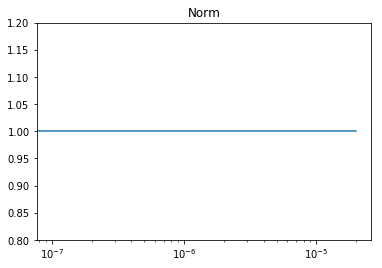

In [314]:
%matplotlib inline
norm=np.sum(prob_stepwise,1)
plt.plot(times,norm)
plt.ylim(0.8,1.2)
plt.xscale("log")
plt.title("Norm");

### 3. Solve_ivp

In [11]:
%%time
# mit ravel
def ME(t, rho):
    rho=rho.reshape((number_atoms,number_atoms))
    terms=copy.copy(rho)
    np.fill_diagonal(terms,0)
    return np.ravel(-1j*(np.dot(H, rho)- np.dot(rho, H)) -gamma*terms)


initial=np.zeros((number_atoms,number_atoms), dtype=complex)
initial[0][0]=1

results = solve_ivp(ME, [0,tend],initial.ravel() ,t_eval=times,rtol=1e-4, atol=1e-6) 

prob_solveivp=np.reshape(results.y,(number_atoms,number_atoms, len(times))).diagonal()
%memit

peak memory: 242.38 MiB, increment: 0.55 MiB
CPU times: user 13.7 s, sys: 5.86 s, total: 19.6 s
Wall time: 5.52 s


/home/jp/.local/lib/python3.5/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


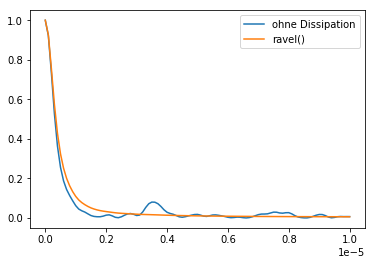

In [12]:
%matplotlib inline
index=0
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(times,prob_exact[:,index], label = "ohne Dissipation")
#ax.plot(times,prob_stepwise[:,index] , label= "Stepwise")
ax.plot(times,prob_solveivp[:,0], label= "ravel()")
ax.ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))

ax.legend();

## Mehrere aufeinmal

In [72]:
gamma1=5*10**-4*coupling_constant
gamma2=5*10**-5*coupling_constant

anzahl1=600
anzahl2=800

densities=np.array([0.1,0.5])
atom_numbers=np.array([anzahl1,anzahl2])
gammas=np.array([gamma1,gamma1])

for i in range(119):
    densities=np.append(densities,0.1)
    densities=np.append(densities,0.5)
    atom_numbers=np.append(atom_numbers,anzahl1)
    atom_numbers=np.append(atom_numbers,anzahl2)
    if i%2 == 0:
        gammas=np.append(gammas,gamma2)
        gammas=np.append(gammas,gamma2)
    else:
        gammas=np.append(gammas,gamma1)
        gammas=np.append(gammas,gamma1)
        
#print(densities)
#print(atom_numbers)
#print(gammas)


tend1=10**-3
step1=0.8*10**-5
times1=np.arange(0,tend1,step1)

tend2=10**-5
step2=0.8*10**-7
times2=np.arange(0,tend2,step2)

tends =np.array([tend1,tend2])
timess=np.array([times1,times2])
print(len(times1))
print(len(times2))
times_exact=np.logspace(-8,-3,125)
prob_exact=Berechnung(eigenvalues,eigenvectors,number_atoms,times_exact)

125
126


In [25]:
angeregt=0
global gamma
global number_atoms
global H

def ME(t, rho):
    rho=rho.reshape((number_atoms,number_atoms))
    terms=copy.copy(rho)
    np.fill_diagonal(terms,0)
    return np.ravel(-1j*(np.dot(H, rho)- np.dot(rho, H)) -gamma*terms)

    
start1=time.time()

for i,density in enumerate(densities):
    start2=time.time()
    number_atoms = atom_numbers[i]     
    tend=tends[i%2]
    times=timess[i%2]
    gamma=gammas[i]
    
    
    radius = (np.sqrt(number_atoms*r_b**2/density))
    atoms_array = produce_atoms(number_atoms,radius,r_b)
    f_atoms = open("files/atoms_"+str(i)+".npy","wb")
    np.save(f_atoms,atoms_array)
    
    #exakt
    eigenvalues, eigenvectors,H = generate_hamiltonian(atoms_array)
    prob_exact=Berechnung(eigenvalues,eigenvectors,number_atoms,times_exact)
    text="density=" +str(np.round(density,3))+", number_atoms="+str(number_atoms)+", gamma="+str(gamma)+ ", tend="+str(tend)
    f_exact = open("files/prob_exact_"+str(i)+".npy","wb")
    np.save(f_exact,prob_exact.squeeze())
    np.save(f_exact,text)

    #Mastereq
    initial=np.zeros((number_atoms,number_atoms), dtype=complex)
    initial[0][0]=1
    
    results = solve_ivp(ME, [0,tend],initial.ravel(), t_eval=times,rtol=1e-4, atol=1e-6) 
    prob_solveivp=np.reshape(results.y,(number_atoms,number_atoms, len(times))).diagonal()
    text="density=" +str(np.round(density,3))+", number_atoms="+str(number_atoms)+", gamma="+str(gamma)+ ", tend="+str(tend)
    f_diss = open("files/prob_diss_"+str(i)+".npy","wb")
    np.save(f_diss,prob_solveivp)
    np.save(f_diss,text)
    
    
    
    print(number_atoms, time.time()-start2)
    

print(time.time()-start1)

600 4003.7961885929108
800 211.9552550315857
600 4444.569423675537
800 242.6438820362091
600 3335.59334564209
800 209.05281972885132
600 4640.705592632294
800 289.9990391731262
600 3410.58323431015
800 197.4245948791504
600 4206.987520933151
800 306.66783571243286


KeyboardInterrupt: 

### Laden

In [43]:
case_1=[0,4,8]
prob_exact_1=[]
prob_diss_1=[]
atoms_1=[]
for i in case_1:
    f_exact = open("files/prob_exact_"+str(i)+".npy","rb")
    prob_exact_1.append(np.load(f_exact))
    text=np.load(f_exact)
    print(text)
    
    f_diss= open("files/prob_diss_"+str(i)+".npy","rb")
    prob_diss_1.append(np.load(f_diss))
    
    f_atoms = open("files/atoms_"+str(i)+".npy","rb")
    atoms_1.append(np.load(f_atoms))

    
case_2=[1,5,9]
prob_exact_2=[]
prob_diss_2=[]
atoms_2=[]
for i in case_2:
    f_exact = open("files/prob_exact_"+str(i)+".npy","rb")
    prob_exact_2.append(np.load(f_exact))
    text=np.load(f_exact)
    print(text)
    
    f_diss= open("files/prob_diss_"+str(i)+".npy","rb")
    prob_diss_2.append(np.load(f_diss))
    
    f_atoms = open("files/atoms_"+str(i)+".npy","rb")
    atoms_2.append(np.load(f_atoms))
    
case_3=[2,6,10]
prob_exact_3=[]
prob_diss_3=[]
atoms_3=[]
for i in case_3:
    f_exact = open("files/prob_exact_"+str(i)+".npy","rb")
    prob_exact_3.append(np.load(f_exact))
    text=np.load(f_exact)
    print(text)
    
    f_diss= open("files/prob_diss_"+str(i)+".npy","rb")
    prob_diss_3.append(np.load(f_diss))
    
    f_atoms = open("files/atoms_"+str(i)+".npy","rb")
    atoms_3.append(np.load(f_atoms))

    
case_4=[3,7,11]
prob_exact_4=[]
prob_diss_4=[]
atoms_4=[]
for i in case_4:
    f_exact = open("files/prob_exact_"+str(i)+".npy","rb")
    prob_exact_4.append(np.load(f_exact))
    text=np.load(f_exact)
    print(text)
    
    f_diss= open("files/prob_diss_"+str(i)+".npy","rb")
    prob_diss_4.append(np.load(f_diss))
    
    f_atoms = open("files/atoms_"+str(i)+".npy","rb")
    atoms_4.append(np.load(f_atoms))

density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001
density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001
density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001
density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05
density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05
density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05
density=0.1, number_atoms=600, gamma=150000.0, tend=0.001
density=0.1, number_atoms=600, gamma=150000.0, tend=0.001
density=0.1, number_atoms=600, gamma=150000.0, tend=0.001
density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05
density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05
density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05


### Animation

In [44]:
def ani_dissipation(atoms_array, prob_normal,prob_diss):
    
     
    %matplotlib notebook
    %matplotlib notebook
    %matplotlib notebook

    
    fig, ax = plt.subplots(1,2, figsize=(9,3.5))
    plt.subplots_adjust(wspace=0.5)
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    plt.set_cmap('jet')
    ax[0].set_title("Without Dissipation")
    ax[1].set_title("With Dissipation")


    time_text = ax[0].annotate('88', xycoords="figure points", xy=(0,10))
    time_text2 = ax[1].annotate('88', xycoords="figure points", xy=(350,10))
    
    scat = ax[0].scatter(atoms_array[:,0], atoms_array[:,1], marker='o',s=17,c=prob_normal[0],
                        norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))
    scat2 = ax[1].scatter(atoms_array[:,0], atoms_array[:,1], marker='o',s=17, c=prob_diss[0],
                      norm=matplotlib.colors.LogNorm(vmin=1*10**-4,vmax=1))

    plt.colorbar(scat, label="probability",ax=ax[0])
    plt.colorbar(scat2, label="probability",ax=ax[1])
    

        
    def animate(i, scat, ):
        time_text.set_text('Time: ' + str(round(times[i],12))+"s" )
        scat.set_array(prob_normal[i])
    
        return scat,time_text,
    
    def animate2(i, scat2, ):
        time_text2.set_text('Time: ' + str(round(times[i],12))+"s" )
        scat2.set_array(prob_diss[i])
        return scat2,time_text2,

    anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(prob_normal),1),fargs=( scat,),interval=200)
    anim2 = animation.FuncAnimation(fig, animate2,
                                   frames=np.arange(0,len(prob_diss),1),fargs=( scat2,),interval=200)
    return anim,anim2

<IPython.core.display.Javascript object>


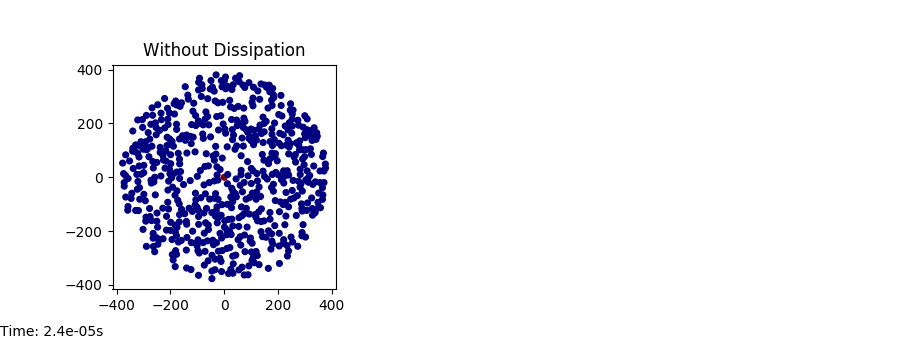

(<matplotlib.animation.FuncAnimation at 0x7f841a1e2828>,
 <matplotlib.animation.FuncAnimation at 0x7f841a1e28d0>)

In [53]:
#ani_dissipation(atoms_array, np.squeeze(prob_exact),prob_stepwise)
ani_dissipation(atoms_1[0], prob_exact_1[0],prob_diss_1[0])

### Auswertung

In [87]:
def auswertung(probability):
        
    # Mean square und mean displacement---------------------------------------------------------------------
    r_2=np.dot(probability,np.power(abstand_ursprung,2))
    r_1=np.dot(probability,abstand_ursprung)
    
    
    #standard deviation -----------------------------------------------------------------------------------
    deviation=np.subtract(r_2,np.square(r_1))
    
    
    
    ipr=1/np.sum(probability**2,axis=1)
    
        
    n_intervall_inf =[]
    density_inf=[]
    density=[]
    for i in range(0,int(radius-d_r),d_r):
        flaeche= np.pi*((i+d_r)**2-i**2)
        index = np.argwhere((i<=abstand_ursprung)& (abstand_ursprung<i+d_r))
        
        n_intervall_inf.append((np.sum(probability[-1][index]))/(flaeche))
            
        laenge= len(index)
        if laenge==0:
            density_inf.append(0)
            density.append(0)
        else:
            density_inf.append(np.sum(probability[-1][index])/len(index))
            density.append(np.sum(probability[50][index])/len(index))

   
    #distribution_width---------------------------------------------------------------------------------

    
    inhalt=0
    global distribution_width
    distribution_width=[]
    
    for i in range(0,len(probability)):
        tmp=copy.copy(abstand_ursprung)
        inhalt=0
        while inhalt<0.9:
            minimum= np.argmin(tmp)
            kk= abstand_ursprung[minimum]
            inhalt+= probability[i][minimum]
            tmp[minimum]=math.inf
        distribution_width.append(kk)
    

    
    
    return np.array(r_1),np.array(r_2), np.array(density), np.array(density_inf),np.array(ipr), np.array(n_intervall_inf), np.array(deviation), np.array(distribution_width)

### Case 1: density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001

In [116]:
global atoms_array
global abstand_ursprung


atoms_array=atoms_1[0]
distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
abstand_ursprung = copy.copy(distance_matrix[:,0])
r_1_normal,r_2_normal, density_normal, density_inf_normal,ipr_normal, n_intervall_inf_normal, deviation_normal, distribution_width_normal=auswertung(prob_exact_1[0][30:])
r_1_stepwise,r_2_stepwise, density_stepwise, density_inf_stepwise,ipr_stepwise, n_intervall_inf_stepwise, deviation_stepwise, distribution_width_stepwise=auswertung(prob_diss_1[0])  


for i in range(0,2):

    atoms_array=atoms_1[i+1]
    distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
    abstand_ursprung = copy.copy(distance_matrix[:,0])
    r_1_normal_tmp,r_2_normal_tmp, density_normal_tmp, density_inf_normal_tmp,ipr_normal_tmp, n_intervall_inf_normal_tmp, deviation_normal_tmp, distribution_width_normal_tmp=auswertung(prob_exact_1[i+1][30:])
    r_1_stepwise_tmp,r_2_stepwise_tmp, density_stepwise_tmp, density_inf_stepwise_tmp,ipr_stepwise_tmp, n_intervall_inf_stepwise_tmp, deviation_stepwise_tmp, distribution_width_stepwise_tmp=auswertung(prob_diss_1[i+1])  

    r_1_normal_prev = r_1_normal
    r_2_normal_prev =  r_2_normal
    density_normal_prev =  density_normal
    density_inf_normal_prev = density_inf_normal
    ipr_normal_prev =  ipr_normal
    n_intervall_inf_normal_prev =  n_intervall_inf_normal
    deviation_normal_prev =  deviation_normal
    distribution_width_normal_prev = distribution_width_normal
    
    r_1_stepwise_prev = r_1_stepwise
    r_2_stepwise_prev =  r_2_stepwise
    density_stepwise_prev =  density_stepwise
    density_inf_stepwise_prev = density_inf_stepwise
    ipr_stepwise_prev =  ipr_stepwise
    n_intervall_inf_stepwise_prev =  n_intervall_inf_stepwise
    deviation_stepwise_prev =  deviation_stepwise
    distribution_width_stepwise_prev = distribution_width_stepwise
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)
    

In [117]:
global d_r
d_r=r_b
global atoms_array
times_exact=np.logspace(-8,-3,125)[30:]
times=times1

density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001



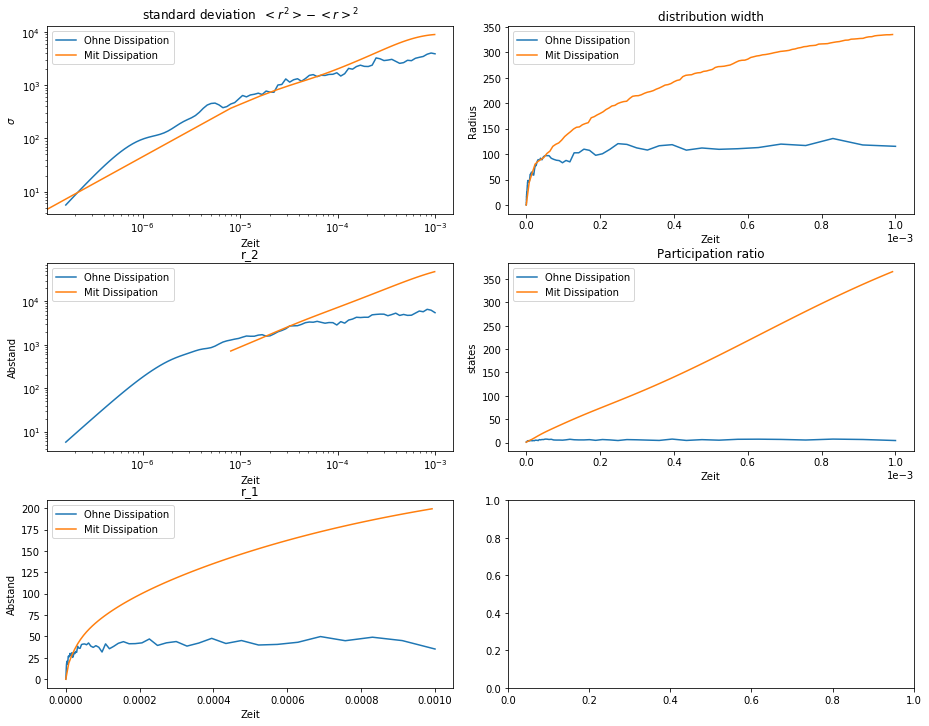

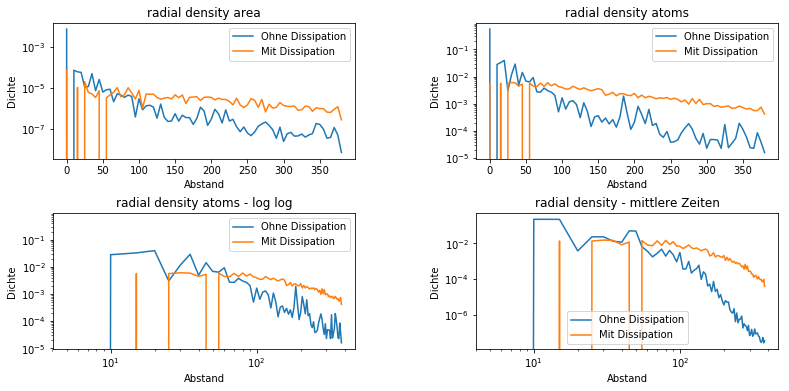

In [118]:
%matplotlib inline
x=np.arange(0,int(radius-d_r),d_r)


print("density=0.1, number_atoms=600, gamma=1500000.0, tend=0.001")
fig, axes = plt.subplots(3,2, figsize=(13,10))  # 2 rows, 2 columns
plt.tight_layout()  
plt.subplots_adjust(wspace=0.2)


#axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
axes[0,0].plot(times_exact, deviation_normal,label="Ohne Dissipation")
axes[0,0].plot(times, deviation_stepwise,label="Mit Dissipation")
axes[0,0].set_yscale("log")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel("Zeit")
axes[0,0].set_ylabel(r"$\sigma$")
axes[0,0].legend();


axes[0,1].set_title("distribution width")
axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(times_exact,distribution_width_normal,label="Ohne Dissipation");
axes[0,1].plot(times,distribution_width_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Zeit")
axes[0,1].set_ylabel("Radius");
axes[0,1].legend();
fig.tight_layout()



axes[1,1].set_title("Participation ratio")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[1,1].plot(times_exact,ipr_normal,label="Ohne Dissipation");
axes[1,1].plot(times,ipr_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Zeit")
axes[1,1].set_ylabel("states");
axes[1,1].legend();


axes[1,0].set_title("r_2")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
#axes[1,0].set_ylim(1,0.5*radius**2)
#axes[1,0].plot(times_exact,quad_func(times,0.1), label=r"$t^2$", color="black", linestyle = "--");
axes[1,0].plot(times_exact,r_2_normal,label="Ohne Dissipation");
axes[1,0].plot(times[1:],r_2_stepwise[1:],label="Mit Dissipation");
axes[1,0].set_xlabel("Zeit")
axes[1,0].set_ylabel("Abstand");
axes[1,0].legend();



axes[2,0].set_title("r_1")
#axes[2,0].set_yscale("log")
#axes[2,0].set_xscale("log")
#axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
#axes[2,0].set_ylim(1,radius)
axes[2,0].plot(times_exact,r_1_normal,label="Ohne Dissipation");
axes[2,0].plot(times,r_1_stepwise,label="Mit Dissipation");
axes[2,0].set_xlabel("Zeit")
axes[2,0].set_ylabel("Abstand");
axes[2,0].legend();


fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
plt.subplots_adjust(wspace=0.4,hspace=0.4)


axes[0,0].set_title("radial density area")
axes[0,0].plot(x,n_intervall_inf_normal, label="Ohne Dissipation");
axes[0,0].plot(x,n_intervall_inf_stepwise,label="Mit Dissipation");
axes[0,0].set_xlabel("Abstand")
axes[0,0].set_ylabel("Dichte")
axes[0,0].set_yscale("log")
axes[0,0].legend();


axes[0,1].set_title("radial density atoms")
#axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[0,1].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Abstand")
axes[0,1].set_ylabel("Dichte");
axes[0,1].set_yscale("log")
axes[0,1].legend();


axes[1,0].set_title("radial density atoms - log log")
axes[1,0].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[1,0].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[1,0].set_xlabel("Abstand")
axes[1,0].set_ylabel("Dichte")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
axes[1,0].legend();

axes[1,1].set_title("radial density - mittlere Zeiten")
axes[1,1].plot(x,density_normal,label="Ohne Dissipation");
axes[1,1].plot(x,density_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Abstand")
axes[1,1].set_ylabel("Dichte")
axes[1,1].set_yscale("log")
axes[1,1].set_xscale("log")
axes[1,1].legend();

print()

### Case2: density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05


In [119]:
global atoms_array

number_atoms=800
atoms_array=atoms_2[0]
distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
abstand_ursprung = copy.copy(distance_matrix[:,0])
r_1_normal,r_2_normal, density_normal, density_inf_normal,ipr_normal, n_intervall_inf_normal, deviation_normal, distribution_width_normal=auswertung(prob_exact_2[0][30:])
r_1_stepwise,r_2_stepwise, density_stepwise, density_inf_stepwise,ipr_stepwise, n_intervall_inf_stepwise, deviation_stepwise, distribution_width_stepwise=auswertung(prob_diss_2[0])  


for i in range(0,2):

    atoms_array=atoms_2[i+1]
    distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
    abstand_ursprung = copy.copy(distance_matrix[:,0])
    r_1_normal_tmp,r_2_normal_tmp, density_normal_tmp, density_inf_normal_tmp,ipr_normal_tmp, n_intervall_inf_normal_tmp, deviation_normal_tmp, distribution_width_normal_tmp=auswertung(prob_exact_2[i+1][30:])
    r_1_stepwise_tmp,r_2_stepwise_tmp, density_stepwise_tmp, density_inf_stepwise_tmp,ipr_stepwise_tmp, n_intervall_inf_stepwise_tmp, deviation_stepwise_tmp, distribution_width_stepwise_tmp=auswertung(prob_diss_2[i+1])  

    r_1_normal_prev = r_1_normal
    r_2_normal_prev =  r_2_normal
    density_normal_prev =  density_normal
    density_inf_normal_prev = density_inf_normal
    ipr_normal_prev =  ipr_normal
    n_intervall_inf_normal_prev =  n_intervall_inf_normal
    deviation_normal_prev =  deviation_normal
    distribution_width_normal_prev = distribution_width_normal
    
    r_1_stepwise_prev = r_1_stepwise
    r_2_stepwise_prev =  r_2_stepwise
    density_stepwise_prev =  density_stepwise
    density_inf_stepwise_prev = density_inf_stepwise
    ipr_stepwise_prev =  ipr_stepwise
    n_intervall_inf_stepwise_prev =  n_intervall_inf_stepwise
    deviation_stepwise_prev =  deviation_stepwise
    distribution_width_stepwise_prev = distribution_width_stepwise
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)
    

In [120]:
global d_r
d_r=r_b
global atoms_array
times_exact=np.logspace(-8,-3,125)[30:]
times=times2

density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05



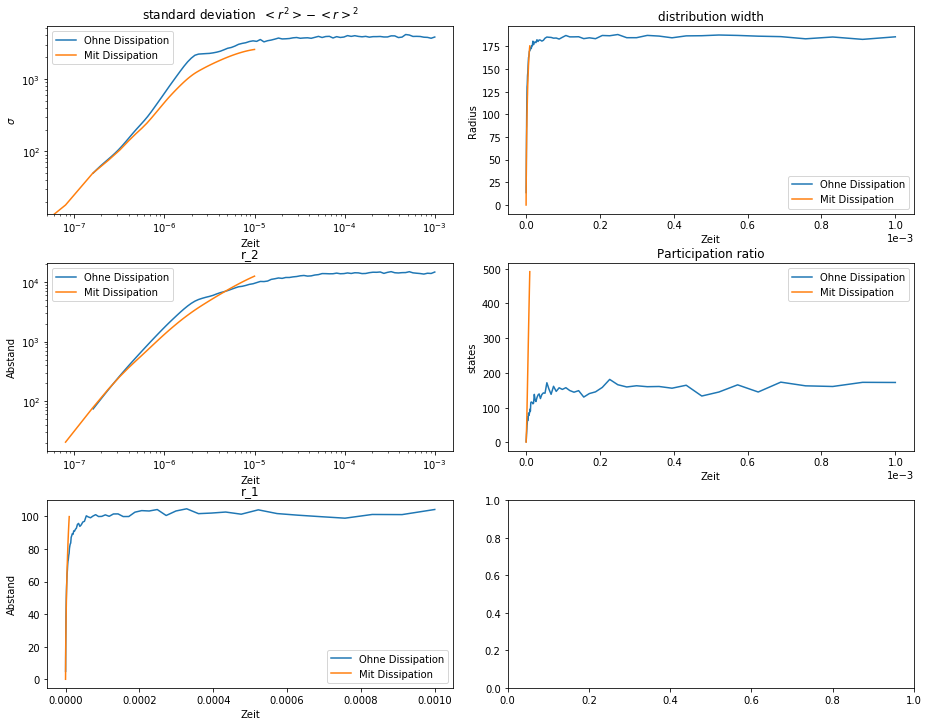

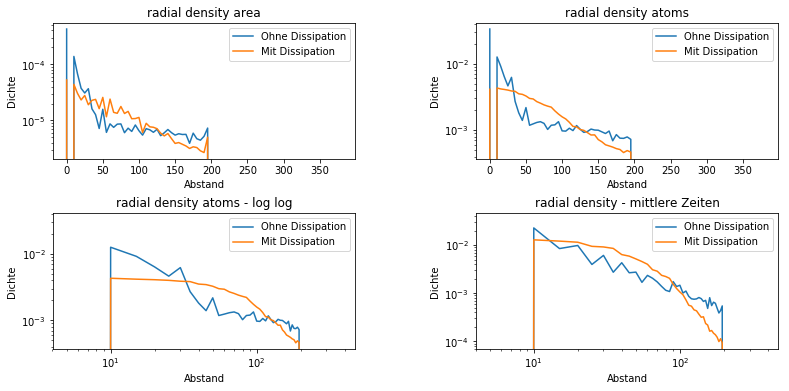

In [121]:
%matplotlib inline
x=np.arange(0,int(radius-d_r),d_r)

print("density=0.5, number_atoms=800, gamma=1500000.0, tend=1e-05")

fig, axes = plt.subplots(3,2, figsize=(13,10))  # 2 rows, 2 columns
plt.tight_layout()  
plt.subplots_adjust(wspace=0.2)


#axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
axes[0,0].plot(times_exact, deviation_normal,label="Ohne Dissipation")
axes[0,0].plot(times, deviation_stepwise,label="Mit Dissipation")
axes[0,0].set_yscale("log")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel("Zeit")
axes[0,0].set_ylabel(r"$\sigma$")
axes[0,0].legend();


axes[0,1].set_title("distribution width")
axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(times_exact,distribution_width_normal,label="Ohne Dissipation");
axes[0,1].plot(times,distribution_width_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Zeit")
axes[0,1].set_ylabel("Radius");
axes[0,1].legend();
fig.tight_layout()



axes[1,1].set_title("Participation ratio")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[1,1].plot(times_exact,ipr_normal,label="Ohne Dissipation");
axes[1,1].plot(times,ipr_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Zeit")
axes[1,1].set_ylabel("states");
axes[1,1].legend();


axes[1,0].set_title("r_2")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
#axes[1,0].set_ylim(1,0.5*radius**2)
#axes[1,0].plot(times_exact,quad_func(times,0.1), label=r"$t^2$", color="black", linestyle = "--");
axes[1,0].plot(times_exact,r_2_normal,label="Ohne Dissipation");
axes[1,0].plot(times[1:],r_2_stepwise[1:],label="Mit Dissipation");
axes[1,0].set_xlabel("Zeit")
axes[1,0].set_ylabel("Abstand");
axes[1,0].legend();



axes[2,0].set_title("r_1")
#axes[2,0].set_yscale("log")
#axes[2,0].set_xscale("log")
#axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
#axes[2,0].set_ylim(1,radius)
axes[2,0].plot(times_exact,r_1_normal,label="Ohne Dissipation");
axes[2,0].plot(times,r_1_stepwise,label="Mit Dissipation");
axes[2,0].set_xlabel("Zeit")
axes[2,0].set_ylabel("Abstand");
axes[2,0].legend();


fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
plt.subplots_adjust(wspace=0.4,hspace=0.4)


axes[0,0].set_title("radial density area")
axes[0,0].plot(x,n_intervall_inf_normal, label="Ohne Dissipation");
axes[0,0].plot(x,n_intervall_inf_stepwise,label="Mit Dissipation");
axes[0,0].set_xlabel("Abstand")
axes[0,0].set_ylabel("Dichte")
axes[0,0].set_yscale("log")
axes[0,0].legend();


axes[0,1].set_title("radial density atoms")
#axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[0,1].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Abstand")
axes[0,1].set_ylabel("Dichte");
axes[0,1].set_yscale("log")
axes[0,1].legend();


axes[1,0].set_title("radial density atoms - log log")
axes[1,0].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[1,0].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[1,0].set_xlabel("Abstand")
axes[1,0].set_ylabel("Dichte")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
axes[1,0].legend();

axes[1,1].set_title("radial density - mittlere Zeiten")
axes[1,1].plot(x,density_normal,label="Ohne Dissipation");
axes[1,1].plot(x,density_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Abstand")
axes[1,1].set_ylabel("Dichte")
axes[1,1].set_yscale("log")
axes[1,1].set_xscale("log")
axes[1,1].legend();

print()

### Case3: density=0.1, number_atoms=600, gamma=150000.0, tend=0.001

In [122]:
global atoms_array
number_atoms=600
atoms_array=atoms_3[0]
distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
abstand_ursprung = copy.copy(distance_matrix[:,0])
r_1_normal,r_2_normal, density_normal, density_inf_normal,ipr_normal, n_intervall_inf_normal, deviation_normal, distribution_width_normal=auswertung(prob_exact_3[0][30:])
r_1_stepwise,r_2_stepwise, density_stepwise, density_inf_stepwise,ipr_stepwise, n_intervall_inf_stepwise, deviation_stepwise, distribution_width_stepwise=auswertung(prob_diss_3[0])  


for i in range(0,2):

    atoms_array=atoms_3[i+1]
    distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
    abstand_ursprung = copy.copy(distance_matrix[:,0])
    r_1_normal_tmp,r_2_normal_tmp, density_normal_tmp, density_inf_normal_tmp,ipr_normal_tmp, n_intervall_inf_normal_tmp, deviation_normal_tmp, distribution_width_normal_tmp=auswertung(prob_exact_3[i+1][30:])
    r_1_stepwise_tmp,r_2_stepwise_tmp, density_stepwise_tmp, density_inf_stepwise_tmp,ipr_stepwise_tmp, n_intervall_inf_stepwise_tmp, deviation_stepwise_tmp, distribution_width_stepwise_tmp=auswertung(prob_diss_3[i+1])  

    r_1_normal_prev = r_1_normal
    r_2_normal_prev =  r_2_normal
    density_normal_prev =  density_normal
    density_inf_normal_prev = density_inf_normal
    ipr_normal_prev =  ipr_normal
    n_intervall_inf_normal_prev =  n_intervall_inf_normal
    deviation_normal_prev =  deviation_normal
    distribution_width_normal_prev = distribution_width_normal
    
    r_1_stepwise_prev = r_1_stepwise
    r_2_stepwise_prev =  r_2_stepwise
    density_stepwise_prev =  density_stepwise
    density_inf_stepwise_prev = density_inf_stepwise
    ipr_stepwise_prev =  ipr_stepwise
    n_intervall_inf_stepwise_prev =  n_intervall_inf_stepwise
    deviation_stepwise_prev =  deviation_stepwise
    distribution_width_stepwise_prev = distribution_width_stepwise
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)
    

In [123]:
global d_r
d_r=r_b
global atoms_array
times_exact=np.logspace(-8,-3,125)[30:]
times=times1

density=0.1, number_atoms=600, gamma=150000.0, tend=0.001



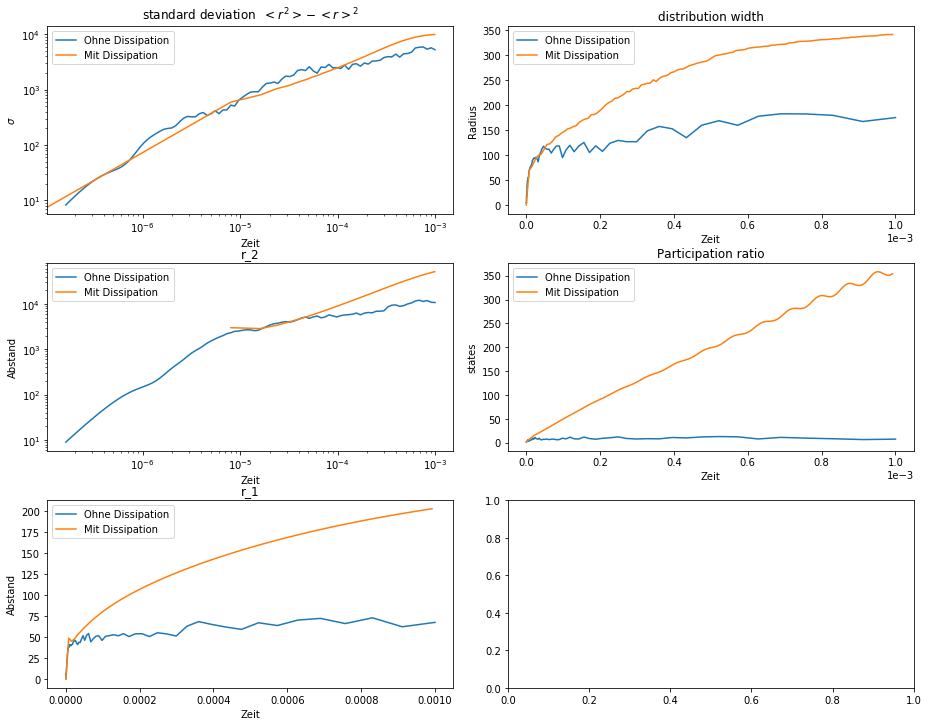

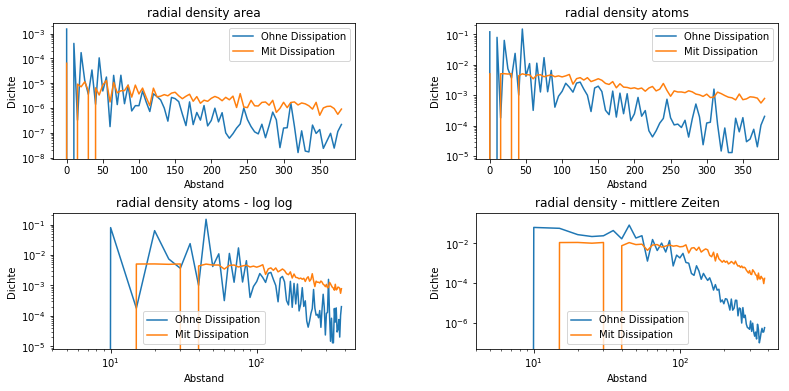

In [124]:
%matplotlib inline
x=np.arange(0,int(radius-d_r),d_r)


print("density=0.1, number_atoms=600, gamma=150000.0, tend=0.001")
fig, axes = plt.subplots(3,2, figsize=(13,10))  # 2 rows, 2 columns
plt.tight_layout()  
plt.subplots_adjust(wspace=0.2)


#axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
axes[0,0].plot(times_exact, deviation_normal,label="Ohne Dissipation")
axes[0,0].plot(times, deviation_stepwise,label="Mit Dissipation")
axes[0,0].set_yscale("log")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel("Zeit")
axes[0,0].set_ylabel(r"$\sigma$")
axes[0,0].legend();


axes[0,1].set_title("distribution width")
axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(times_exact,distribution_width_normal,label="Ohne Dissipation");
axes[0,1].plot(times,distribution_width_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Zeit")
axes[0,1].set_ylabel("Radius");
axes[0,1].legend();
fig.tight_layout()



axes[1,1].set_title("Participation ratio")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[1,1].plot(times_exact,ipr_normal,label="Ohne Dissipation");
axes[1,1].plot(times,ipr_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Zeit")
axes[1,1].set_ylabel("states");
axes[1,1].legend();


axes[1,0].set_title("r_2")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
#axes[1,0].set_ylim(1,0.5*radius**2)
#axes[1,0].plot(times_exact,quad_func(times,0.1), label=r"$t^2$", color="black", linestyle = "--");
axes[1,0].plot(times_exact,r_2_normal,label="Ohne Dissipation");
axes[1,0].plot(times[1:],r_2_stepwise[1:],label="Mit Dissipation");
axes[1,0].set_xlabel("Zeit")
axes[1,0].set_ylabel("Abstand");
axes[1,0].legend();



axes[2,0].set_title("r_1")
#axes[2,0].set_yscale("log")
#axes[2,0].set_xscale("log")
#axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
#axes[2,0].set_ylim(1,radius)
axes[2,0].plot(times_exact,r_1_normal,label="Ohne Dissipation");
axes[2,0].plot(times,r_1_stepwise,label="Mit Dissipation");
axes[2,0].set_xlabel("Zeit")
axes[2,0].set_ylabel("Abstand");
axes[2,0].legend();


fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
plt.subplots_adjust(wspace=0.4,hspace=0.4)


axes[0,0].set_title("radial density area")
axes[0,0].plot(x,n_intervall_inf_normal, label="Ohne Dissipation");
axes[0,0].plot(x,n_intervall_inf_stepwise,label="Mit Dissipation");
axes[0,0].set_xlabel("Abstand")
axes[0,0].set_ylabel("Dichte")
axes[0,0].set_yscale("log")
axes[0,0].legend();


axes[0,1].set_title("radial density atoms")
#axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[0,1].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Abstand")
axes[0,1].set_ylabel("Dichte");
axes[0,1].set_yscale("log")
axes[0,1].legend();


axes[1,0].set_title("radial density atoms - log log")
axes[1,0].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[1,0].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[1,0].set_xlabel("Abstand")
axes[1,0].set_ylabel("Dichte")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
axes[1,0].legend();

axes[1,1].set_title("radial density - mittlere Zeiten")
axes[1,1].plot(x,density_normal,label="Ohne Dissipation");
axes[1,1].plot(x,density_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Abstand")
axes[1,1].set_ylabel("Dichte")
axes[1,1].set_yscale("log")
axes[1,1].set_xscale("log")
axes[1,1].legend();

print()

### Case4: density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05

In [125]:
global atoms_array

number_atoms=800
atoms_array=atoms_4[0]
distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
abstand_ursprung = copy.copy(distance_matrix[:,0])
r_1_normal,r_2_normal, density_normal, density_inf_normal,ipr_normal, n_intervall_inf_normal, deviation_normal, distribution_width_normal=auswertung(prob_exact_4[0][30:])
r_1_stepwise,r_2_stepwise, density_stepwise, density_inf_stepwise,ipr_stepwise, n_intervall_inf_stepwise, deviation_stepwise, distribution_width_stepwise=auswertung(prob_diss_4[0])  


for i in range(0,2):

    atoms_array=atoms_4[i+1]
    distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
    abstand_ursprung = copy.copy(distance_matrix[:,0])
    r_1_normal_tmp,r_2_normal_tmp, density_normal_tmp, density_inf_normal_tmp,ipr_normal_tmp, n_intervall_inf_normal_tmp, deviation_normal_tmp, distribution_width_normal_tmp=auswertung(prob_exact_4[i+1][30:])
    r_1_stepwise_tmp,r_2_stepwise_tmp, density_stepwise_tmp, density_inf_stepwise_tmp,ipr_stepwise_tmp, n_intervall_inf_stepwise_tmp, deviation_stepwise_tmp, distribution_width_stepwise_tmp=auswertung(prob_diss_4[i+1])  

    r_1_normal_prev = r_1_normal
    r_2_normal_prev =  r_2_normal
    density_normal_prev =  density_normal
    density_inf_normal_prev = density_inf_normal
    ipr_normal_prev =  ipr_normal
    n_intervall_inf_normal_prev =  n_intervall_inf_normal
    deviation_normal_prev =  deviation_normal
    distribution_width_normal_prev = distribution_width_normal
    
    r_1_stepwise_prev = r_1_stepwise
    r_2_stepwise_prev =  r_2_stepwise
    density_stepwise_prev =  density_stepwise
    density_inf_stepwise_prev = density_inf_stepwise
    ipr_stepwise_prev =  ipr_stepwise
    n_intervall_inf_stepwise_prev =  n_intervall_inf_stepwise
    deviation_stepwise_prev =  deviation_stepwise
    distribution_width_stepwise_prev = distribution_width_stepwise
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)
    

In [126]:
global d_r
d_r=r_b
global atoms_array
times_exact=np.logspace(-8,-3,125)[30:]
times=times2

density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05



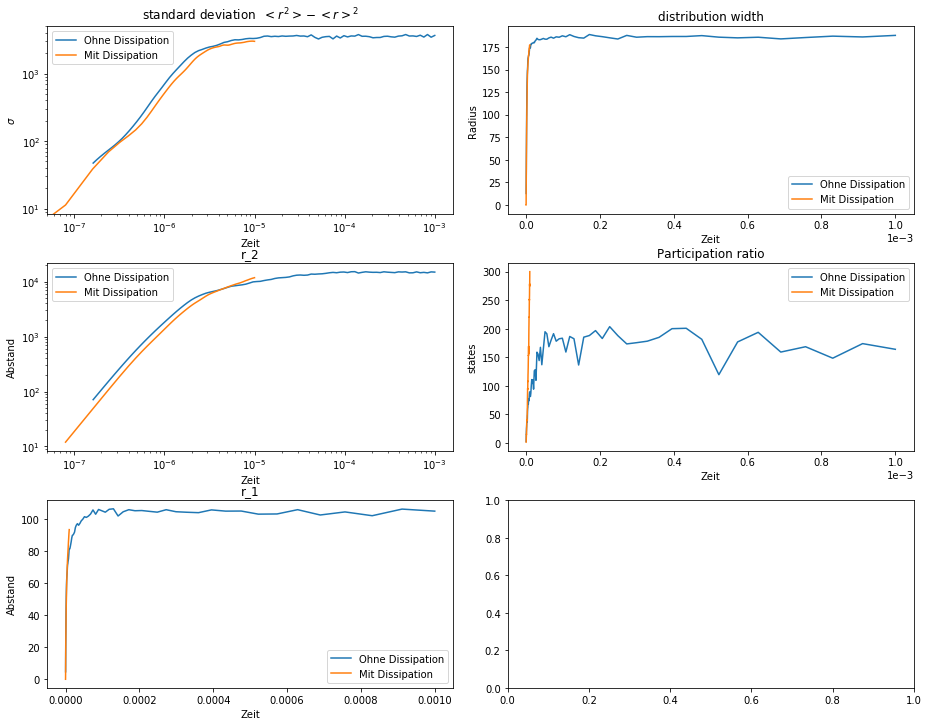

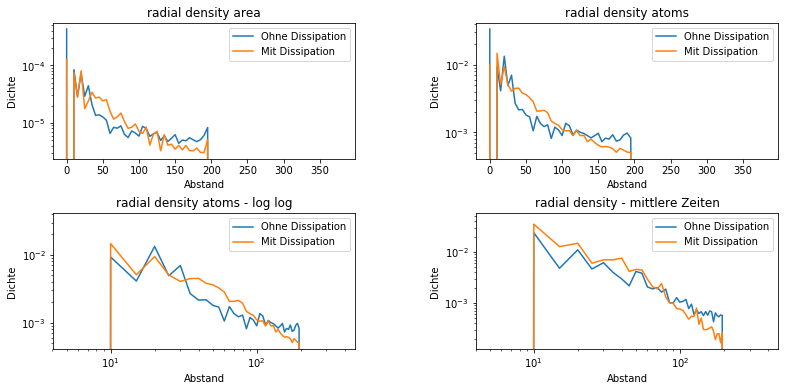

In [127]:
%matplotlib inline
x=np.arange(0,int(radius-d_r),d_r)


print("density=0.5, number_atoms=800, gamma=150000.0, tend=1e-05")
fig, axes = plt.subplots(3,2, figsize=(13,10))  # 2 rows, 2 columns
plt.tight_layout()  
plt.subplots_adjust(wspace=0.2)


#axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
axes[0,0].plot(times_exact, deviation_normal,label="Ohne Dissipation")
axes[0,0].plot(times, deviation_stepwise,label="Mit Dissipation")
axes[0,0].set_yscale("log")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel("Zeit")
axes[0,0].set_ylabel(r"$\sigma$")
axes[0,0].legend();


axes[0,1].set_title("distribution width")
axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(times_exact,distribution_width_normal,label="Ohne Dissipation");
axes[0,1].plot(times,distribution_width_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Zeit")
axes[0,1].set_ylabel("Radius");
axes[0,1].legend();
fig.tight_layout()



axes[1,1].set_title("Participation ratio")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[1,1].plot(times_exact,ipr_normal,label="Ohne Dissipation");
axes[1,1].plot(times,ipr_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Zeit")
axes[1,1].set_ylabel("states");
axes[1,1].legend();


axes[1,0].set_title("r_2")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
#axes[1,0].set_ylim(1,0.5*radius**2)
#axes[1,0].plot(times_exact,quad_func(times,0.1), label=r"$t^2$", color="black", linestyle = "--");
axes[1,0].plot(times_exact,r_2_normal,label="Ohne Dissipation");
axes[1,0].plot(times[1:],r_2_stepwise[1:],label="Mit Dissipation");
axes[1,0].set_xlabel("Zeit")
axes[1,0].set_ylabel("Abstand");
axes[1,0].legend();



axes[2,0].set_title("r_1")
#axes[2,0].set_yscale("log")
#axes[2,0].set_xscale("log")
#axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
#axes[2,0].set_ylim(1,radius)
axes[2,0].plot(times_exact,r_1_normal,label="Ohne Dissipation");
axes[2,0].plot(times,r_1_stepwise,label="Mit Dissipation");
axes[2,0].set_xlabel("Zeit")
axes[2,0].set_ylabel("Abstand");
axes[2,0].legend();


fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
plt.subplots_adjust(wspace=0.4,hspace=0.4)


axes[0,0].set_title("radial density area")
axes[0,0].plot(x,n_intervall_inf_normal, label="Ohne Dissipation");
axes[0,0].plot(x,n_intervall_inf_stepwise,label="Mit Dissipation");
axes[0,0].set_xlabel("Abstand")
axes[0,0].set_ylabel("Dichte")
axes[0,0].set_yscale("log")
axes[0,0].legend();


axes[0,1].set_title("radial density atoms")
#axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[0,1].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Abstand")
axes[0,1].set_ylabel("Dichte");
axes[0,1].set_yscale("log")
axes[0,1].legend();


axes[1,0].set_title("radial density atoms - log log")
axes[1,0].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[1,0].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[1,0].set_xlabel("Abstand")
axes[1,0].set_ylabel("Dichte")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
axes[1,0].legend();

axes[1,1].set_title("radial density - mittlere Zeiten")
axes[1,1].plot(x,density_normal,label="Ohne Dissipation");
axes[1,1].plot(x,density_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Abstand")
axes[1,1].set_ylabel("Dichte")
axes[1,1].set_yscale("log")
axes[1,1].set_xscale("log")
axes[1,1].legend();

print()